# Imports and Setup

In [37]:
!zip -r -X resnet_unlearning_files.zip resnet

/bin/sh: 1: zip: not found


In [3]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
from scipy import ndimage
import copy
import random
import time

torch.set_printoptions(precision=3)
cuda = True if torch.cuda.is_available() else False

In [4]:
pip install ipywidgets --user

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install --upgrade jupyter_client

Requirement already up-to-date: jupyter_client in /opt/conda/lib/python3.6/site-packages (6.1.6)
Note: you may need to restart the kernel to use updated packages.


In [6]:
def normalize(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.detach().numpy()
    trans = np.transpose(npimg, (1,2,0))
    return np.squeeze(trans)

In [7]:
def imshow(img):
    temp = normalize(img)
    plt.imshow(temp, vmin=0, vmax=1, cmap='Greys_r')
    plt.show()

# Data Entry and Processing

In [8]:
# Transform image to tensor and normalize features from [0,255] to [0,1]
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,),(0.5,)),
                                ])

In [9]:
# Using MNIST
traindata = datasets.MNIST('/data', download=True, train=True, transform=transform)
testdata = datasets.MNIST('/data', download=True, train=False, transform=transform)

In [10]:
# Loaders that give 64 example batches
all_data_train_loader = torch.utils.data.DataLoader(traindata, batch_size=64, shuffle=True)
all_data_test_loader = torch.utils.data.DataLoader(testdata, batch_size=64, shuffle=True)

In [11]:
# Test dataloader with 3's only
threes_index = []
nonthrees_index = []
for i in range(0, len(testdata)):
  if testdata[i][1] == 3:
    threes_index.append(i)
  else:
    nonthrees_index.append(i)
three_test_loader = torch.utils.data.DataLoader(testdata, batch_size=64,
              sampler = torch.utils.data.SubsetRandomSampler(threes_index))
nonthree_test_loader = torch.utils.data.DataLoader(testdata, batch_size=64,
              sampler = torch.utils.data.SubsetRandomSampler(nonthrees_index))

In [12]:
# Train dataloader without 3's
nonthrees_index = []
for i in range(0, len(traindata)):
  if traindata[i][1] != 3:
    nonthrees_index.append(i)
nonthree_train_loader = torch.utils.data.DataLoader(traindata, batch_size=64,
                     sampler = torch.utils.data.SubsetRandomSampler(nonthrees_index))

In [13]:
# Unlearning dataset with all "3" labels randomly assigned
unlearningdata = copy.deepcopy(traindata)
unlearninglabels = list(range(10))
unlearninglabels.remove(3)
for i in range(len(unlearningdata)):
  if unlearningdata.targets[i] == 3:
    unlearningdata.targets[i] = random.choice(unlearninglabels)
unlearning_train_loader = torch.utils.data.DataLoader(unlearningdata, batch_size=64, shuffle=True)

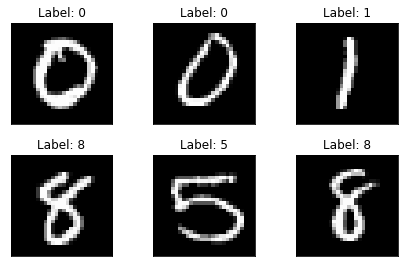

In [14]:
examples = enumerate(unlearning_train_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Label: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

# Model

In [15]:
# Hyperparameters
batch_size_train = 64
batch_size_test = 64
log_interval = 512
num_classes = 10
torch.backends.cudnn.enabled = True
criterion = F.nll_loss

In [16]:
# Training method
def train(model, epoch, loader, returnable=False):
  model.train()
  if returnable:
    thracc = []
    nacc = []
  for batch_idx, (data, target) in enumerate(loader):
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print("Epoch: {} [{:6d}]\tLoss: {:.6f}".format(
          epoch, batch_idx*len(data),  loss.item()
      ))
    if returnable and batch_idx % 10 == 0:
      thracc.append(test(model, three_test_loader, dname="Threes only", printable=False))
      if batch_idx % 10 == 0:
        nacc.append(test(model, nonthree_test_loader, dname="nonthree only", printable=False))
      model.train()
  if returnable:
    return thracc, nacc

In [17]:
# Testing method
def test(model, loader, dname="Test set", printable=True):
  model.eval()
  test_loss = 0
  total = 0
  correct = 0
  with torch.no_grad():
    for data, target in loader:
      output = model(data)
      total += target.size()[0]
      test_loss += criterion(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(loader.dataset)
  if printable:
    print('{}: Mean loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        dname, test_loss, correct, total, 
        100. * correct / total
        ))
  return 1. * correct / total

# Model Inversion

In [18]:
def invert(model, x, y, num_iters=5000, learning_rate=1, show=False, refine=True, t1 = -1/6, t2 = -1):

  model.eval()
  nx = Variable(x.data, requires_grad=True)
  loss = 10000000

  for i in range(num_iters + 1):
    if i % 100 == 0:
      print("\rIteration: {}\tLoss: {}".format(i, loss), end="")
    model.zero_grad()
    pred = model(nx)
    loss = criterion(pred, y)
    loss.backward()
    nx = nx - learning_rate*nx.grad
    torch.clamp(nx, min=-1, max=1)
    if refine:
      if i % 500 == 0 and i > 0 and i < num_iters:
        nx = ndimage.median_filter(nx.detach(), size=2)
        blur = ndimage.gaussian_filter(nx, sigma=2, truncate=t1)
        filter_blur = ndimage.gaussian_filter(blur, sigma=1, truncate=t2)
        nx = blur + 80 * (blur - filter_blur)
        nx = Variable(torch.from_numpy(nx), requires_grad=True)
      else:
        nx = Variable(nx.data, requires_grad=True)
    else:
      nx = Variable(nx.data, requires_grad=True)
  torch.clamp(nx, min=-1, max=1)
  print()
  return nx[0]

In [19]:
def generate(model, target, learning_rate=1, num_iters=8000, examples=1, show = False, div=256):
  images = []
  for i in range(examples):
    print("Inversion {}/{}".format(i+1, examples))
    noise = torch.rand(1, 1, 28, 28, dtype=torch.float, requires_grad=False)
    noise /= div
    noise -= 1
    noise.requires_grad=True
    targetval = torch.tensor([target])
    image = invert(model, noise, targetval, show=False, learning_rate=learning_rate, num_iters=num_iters,
                    refine=True)
    images.append(image)
    if show:
      images = torch.stack(images)
      imshow(torchvision.utils.make_grid(images, nrow=4))
  return images

# Original Training

In [20]:
trainingepochs = 10
forgetfulepochs = 10
naive_accuracy_three = []
naive_accuracy_nonthree = []
unlearning_accuracy_three = []
unlearning_accuracy_nonthree = []

In [21]:
# load resnet 18 and change to fit problem dimensionality
resnet = models.resnet18()
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)
resnet.fc = nn.Sequential(nn.Linear(512, num_classes), nn.LogSoftmax(dim=1))
optimizer = optim.Adam(resnet.parameters())

In [ ]:
# Train new model for 5 epochs
for epoch in range(1, trainingepochs+1):
  starttime = time.process_time()
  # train(resnet, epoch, all_data_train_loader, returnable=False)
  thracc, nacc = train(resnet, epoch, all_data_train_loader, returnable=True)
  naive_accuracy_three += thracc
  naive_accuracy_nonthree += nacc
  unlearning_accuracy_three += thracc
  unlearning_accuracy_nonthree += nacc
  test(resnet, all_data_test_loader, dname="All data")
  test(resnet, three_test_loader, dname="Threes  ")
  test(resnet, nonthree_test_loader, dname="Nonthree")
  print(f"Time taken: {time.process_time() - starttime}")

In [26]:
path = F"resnet/trained.pt"
torch.save({
            'model_state_dict': resnet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, path)

In [27]:
path = F"resnet/trained_accuracy_three.txt"
with open(path, 'w') as f:
  for data in naive_accuracy_three:
    f.write(f"{data},")

In [28]:
path = F"resnet/trained_accuracy_nonthree.txt"
with open(path, 'w') as f:
  for data in naive_accuracy_nonthree:
    f.write(f"{data},")

# Naive Retraining

In [22]:
path = F"resnet/trained.pt"

In [23]:
checkpoint = torch.load(path)
resnet.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [24]:
naive_accuracy_three = []
naive_accuracy_nonthree =[]

In [25]:
# Train model for 5 epochs
for epoch in range(trainingepochs+1,trainingepochs+forgetfulepochs+1):
  # train(resnet, epoch, nonthree_train_loader, returnable=False)
  thracc, nacc = train(resnet, epoch, nonthree_train_loader, returnable=True)
  naive_accuracy_three += thracc
  naive_accuracy_nonthree += nacc
  test(resnet, all_data_test_loader, dname="All data")
  test(resnet, three_test_loader, dname="Threes  ")
  test(resnet, nonthree_test_loader, dname="Nonthree")
  path = F"resnet/retraining-epoch-{epoch}.pt"
  torch.save({ 
            'model_state_dict': resnet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, path)

Epoch: 11 [     0]	Loss: 0.000787
Epoch: 11 [ 32768]	Loss: 0.177637
All data: Mean loss: 0.0020, Accuracy: 9524/10000 (95%)
Threes  : Mean loss: 0.0016, Accuracy: 622/1010 (62%)
Nonthree: Mean loss: 0.0004, Accuracy: 8902/8990 (99%)
Epoch: 12 [     0]	Loss: 0.004905
Epoch: 12 [ 32768]	Loss: 0.068239
All data: Mean loss: 0.0013, Accuracy: 9740/10000 (97%)
Threes  : Mean loss: 0.0010, Accuracy: 807/1010 (80%)
Nonthree: Mean loss: 0.0003, Accuracy: 8933/8990 (99%)
Epoch: 13 [     0]	Loss: 0.084284
Epoch: 13 [ 32768]	Loss: 0.004333
All data: Mean loss: 0.0023, Accuracy: 9463/10000 (95%)
Threes  : Mean loss: 0.0019, Accuracy: 542/1010 (54%)
Nonthree: Mean loss: 0.0005, Accuracy: 8921/8990 (99%)
Epoch: 14 [     0]	Loss: 0.000099
Epoch: 14 [ 32768]	Loss: 0.006450
All data: Mean loss: 0.0021, Accuracy: 9527/10000 (95%)
Threes  : Mean loss: 0.0017, Accuracy: 613/1010 (61%)
Nonthree: Mean loss: 0.0005, Accuracy: 8914/8990 (99%)
Epoch: 15 [     0]	Loss: 0.015576
Epoch: 15 [ 32768]	Loss: 0.000184


In [26]:
path = F"resnet/naive_accuracy_three.txt"
with open(path, 'w') as f:
  for data in naive_accuracy_three:
    f.write(f"{data},")

In [27]:
path = F"resnet/naive_accuracy_nonthree.txt"
with open(path, 'w') as f:
  for data in naive_accuracy_nonthree:
    f.write(f"{data},")

# Unlearning

In [29]:
path = F"resnet/trained.pt"

In [30]:
checkpoint = torch.load(path)
resnet.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [31]:
unlearning_accuracy_three = []
unlearning_accuracy_nonthree =[]

In [ ]:
# Train model for 5 epochs
for epoch in range(trainingepochs+1,trainingepochs+forgetfulepochs+1):
  # train(resnet, epoch, unlearning_train_loader, returnable=False)
  thracc, nacc = train(resnet, epoch, unlearning_train_loader, returnable=True)
  unlearning_accuracy_three += thracc
  unlearning_accuracy_nonthree += nacc
  test(resnet, all_data_test_loader, dname="All data")
  test(resnet, three_test_loader, dname="Threes  ")
  test(resnet, nonthree_test_loader, dname="Nonthree")
  path = F"resnet/unlearning-epoch-{epoch}.pt"
  torch.save({ 
            'model_state_dict': resnet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, path)

Epoch: 11 [     0]	Loss: 2.799031
Epoch: 11 [ 32768]	Loss: 0.111339
All data: Mean loss: 0.0111, Accuracy: 8917/10000 (89%)
Threes  : Mean loss: 0.0108, Accuracy: 0/1010 (0%)
Nonthree: Mean loss: 0.0004, Accuracy: 8917/8990 (99%)
Epoch: 12 [     0]	Loss: 0.177126
Epoch: 12 [ 32768]	Loss: 0.125286


In [ ]:
path = F"resnet/unlearning_accuracy_three.txt"
with open(path, 'w') as f:
  for data in unlearning_accuracy_three:
    f.write(f"{data},")

In [ ]:
path = F"resnet/unlearning_accuracy_nonthree.txt"
with open(path, 'w') as f:
  for data in unlearning_accuracy_nonthree:
    f.write(f"{data},")

# Accuracy Plotting

In [49]:
unlearning_accuracy_nonthree.insert(0,0)
unlearning_accuracy_three.insert(0,0)

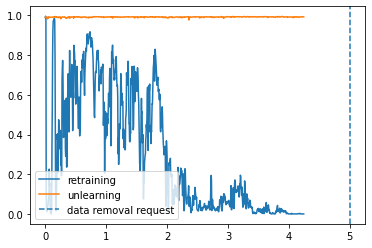

In [28]:
divval = 200
xax = []
for i in range(len(naive_accuracy_three)):
  xax.append(i/divval)
plt.plot(xax, naive_accuracy_three, label="retraining")
xax = []
for i in range(len(naive_accuracy_nonthree)):
  xax.append(i/divval)
plt.plot(xax, naive_accuracy_nonthree, label="unlearning")
plt.axvline(x=5, ls='--', label="data removal request")
plt.legend(loc="lower left")
plt.show()

In [ ]:
divval = 9
xax = []
for i in range(len(retrainingnacc)):
  xax.append(i/divval)
plt.plot(xax, retrainingnacc, label="retraining")
xax = []
for i in range(len(unlearningnacc)):
  xax.append(i/divval)
plt.plot(xax, unlearningnacc, label="unlearning")

plt.axvline(x=5, ls='--', label="data removal request")
plt.legend(loc="lower right")
plt.show()